In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
seed(123)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time

from IPython.display import SVG
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance


ImportError: No module named 'xgboost'

In [25]:
df_2019 = pd.read_excel('data/airbnb_April_Sep2019.xlsx')
df_2020 = pd.read_excel('data/airbnb_April_Sep2020.xlsx')

In [26]:
df_2019.head()
df_2020.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month
0,1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,76,1,354,2020-09-20,4.82,1,2,2020,9
1,7,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66829,-73.98779,Private room,82,4,181,2020-09-09,1.30,3,0,2020,9
2,11,7097,Perfect for Your Parents + Garden; Germ-Free,17571,Jane,Brooklyn,Fort Greene,40.69121,-73.97277,Entire home/apt,191,2,233,2020-09-28,1.78,2,331,2020,9
3,14,8490,"MAISON DES SIRENES1,bohemian apartment",25183,Nathalie,Brooklyn,Bedford-Stuyvesant,40.68371,-73.94028,Entire home/apt,120,2,116,2020-09-07,0.86,2,352,2020,9
4,16,9657,Modern 1 BR / NYC / East Village,21904,Dana,Manhattan,East Village,40.72920,-73.98542,Entire home/apt,175,3,34,2020-09-30,0.25,1,90,2020,9


In [27]:
# drop unnessary columns
#last_review was dropped, because all the data are from 2019.4-2019.10,and we already extract the month from the date. 
df_2019 = df_2019.drop(['name','host_id','host_name','latitude','longitude','last_review'], axis=1)
df_2020 = df_2020.drop(['name','host_id','host_name','latitude','longitude','last_review'], axis=1)

In [28]:
#check the null values
df_2019.isna().sum()

Unnamed: 0                        0
id                                0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
review_year                       0
review_month                      0
dtype: int64

In [29]:
df_2020.isna().sum()

Unnamed: 0                        0
id                                0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
review_year                       0
review_month                      0
dtype: int64

In [30]:
df_2019.set_index('id', inplace=True)
df_2020.set_index('id', inplace=True)

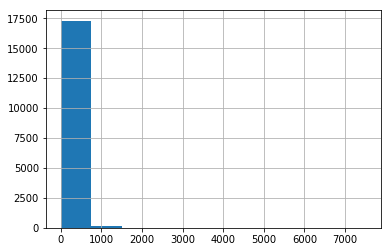

In [31]:
df_2019['price'].hist();

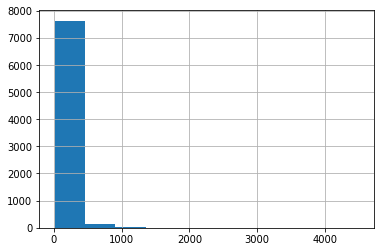

In [32]:
df_2020['price'].hist();

In [33]:
print(max(df_2019['price']))
print(max(df_2020['price']))

7500
4500


### There are some outliers for the price. In order to avoid underfitting or overfitting, we only keep the prive under 1000.
#### Remove:
* Price >= above 95th quantile 
* minimum_nights >= 365


In [34]:
df_19 = df_2019[(df_2019['price']<=350) & (df_2019['minimum_nights']<=365)]
df_20 = df_2020[(df_2020['price']<=300) & (df_2020['minimum_nights']<=365)]

In [35]:
df_19['minimum_nights'].unique()

array([  1,   3,   2,   5,   4,   7,  29,  30,  20,  31,   6,   8,  45,
        28, 200,  14,  25,  35,  40,  44,  10,  90,  21,  19,  12, 115,
        15,   9,  60,  26,  18,  75, 120,  16,  13,  27,  22, 365, 180,
        11,  24,  59,  50, 130, 150, 135,  23,  80, 100, 300,  42,  56,
        32,  38, 210,  85,  89,  55,  62])

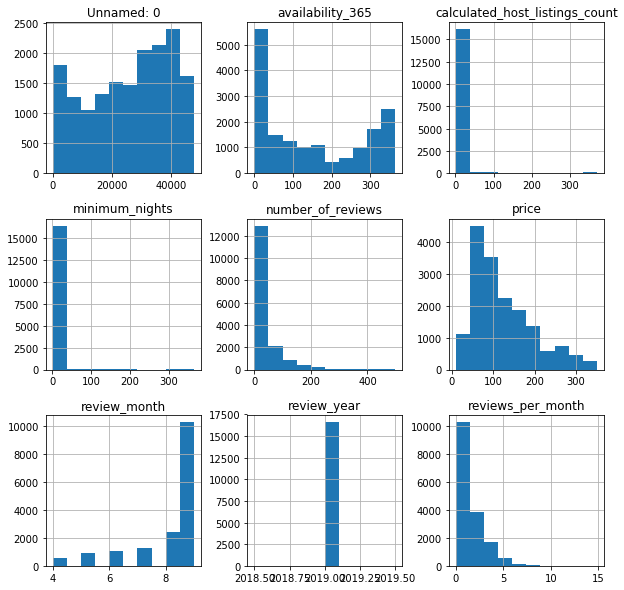

In [36]:
# Plotting the distribution
df_19.hist(figsize=(10,10));

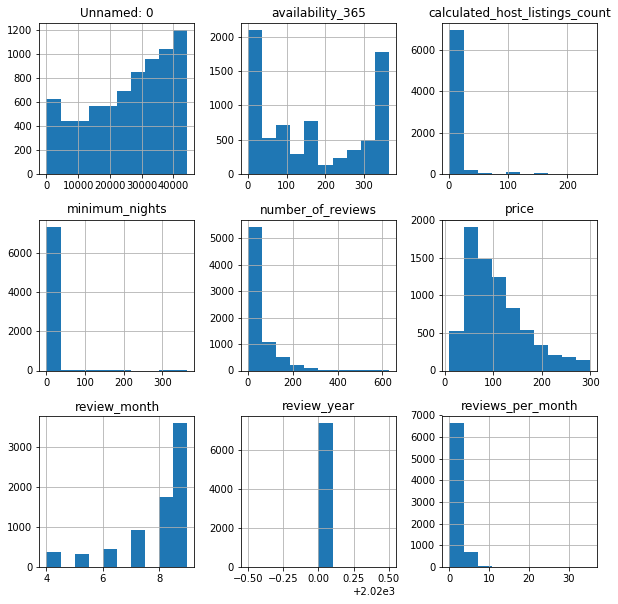

In [37]:
df_20.hist(figsize=(10,10));

In [38]:
#rename the review_month column values
df_19['review_month'] = df_19['review_month'].replace([4,5,6,7,8,9],['review_April','review_May','review_June','review_July','review_Aug','review_Sept'])
df_20['review_month'] = df_20['review_month'].replace([4,5,6,7,8,9],['review_April','review_May','review_June','review_July','review_Aug','review_Sept'])

/Users/sophiezhao/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sophiezhao/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
df_19.describe()

,Unnamed: 0,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year
count,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.0
mean,25705.913101,122.193657,6.580550,35.409400,1.534675,8.258831,146.311187,2019.0
std,13846.362002,71.744050,13.021367,51.156322,1.422935,40.335612,134.088595,0.0
min,0.000000,10.000000,1.000000,1.000000,0.020000,1.000000,0.000000,2019.0
25%,14434.000000,65.000000,2.000000,5.000000,0.470000,1.000000,11.000000,2019.0
50%,28241.000000,100.000000,2.000000,14.000000,1.030000,1.000000,109.000000,2019.0
75%,37849.000000,160.000000,5.000000,44.000000,2.190000,3.000000,293.000000,2019.0
max,47615.000000,350.000000,365.000000,498.000000,14.850000,371.000000,365.000000,2019.0


In [40]:
df_20.describe()

,Unnamed: 0,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year
count,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.000000,7400.0
mean,26120.386892,105.271622,8.553514,49.724730,1.688445,7.254865,166.781081,2020.0
std,12936.877397,60.818117,15.358151,67.564337,1.593890,21.544415,139.718047,0.0
min,1.000000,10.000000,1.000000,1.000000,0.030000,1.000000,0.000000,2020.0
25%,16181.750000,56.000000,1.000000,5.000000,0.560000,1.000000,19.000000,2020.0
50%,28671.500000,91.000000,3.000000,21.000000,1.205000,2.000000,153.000000,2020.0
75%,37411.000000,140.000000,7.000000,68.000000,2.412500,4.000000,325.000000,2020.0
max,44463.000000,300.000000,365.000000,629.000000,35.450000,239.000000,365.000000,2020.0


In [41]:
print("Median number of listings per host:", int(df_19.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_19.calculated_host_listings_count.mean())))
#print(f"{int(round(100*len(df_19[df_19.calculated_host_listings_count == 1])/len(df_19)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 8


In [42]:
print("Median number of listings per host:", int(df_20.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_20.calculated_host_listings_count.mean())))
#print(f"{int(round(100*len(df_20[df_20.calculated_host_listings_count == 1])/len(df_20)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 7


### One-hot encoding
#### Convert all categorical variables into dummy variables

#### 1. Try convert all the neighbourhood into dummy variables (not just neighbourhood group) 
* There will be more than 200 neighbourhood area. If it doesn't work well, we can only use 5 neighbourhood groups

In [43]:
df_19 = df_19.drop(['Unnamed: 0'],axis = 1) 
df_20 = df_20.drop(['Unnamed: 0'],axis = 1) 

In [44]:
df_19
df_20

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month
id,,,,,,,,,,,
3831,Brooklyn,Clinton Hill,Entire home/apt,76,1,354,4.82,1,2,2020,review_Sept
5803,Brooklyn,South Slope,Private room,82,4,181,1.30,3,0,2020,review_Sept
7097,Brooklyn,Fort Greene,Entire home/apt,191,2,233,1.78,2,331,2020,review_Sept
8490,Brooklyn,Bedford-Stuyvesant,Entire home/apt,120,2,116,0.86,2,352,2020,review_Sept
9657,Manhattan,East Village,Entire home/apt,175,3,34,0.25,1,90,2020,review_Sept
10962,Brooklyn,South Slope,Private room,82,4,181,1.35,3,359,2020,review_Sept
12940,Brooklyn,Bedford-Stuyvesant,Entire home/apt,100,5,67,0.51,1,21,2020,review_Aug
13808,Brooklyn,Bedford-Stuyvesant,Private room,81,2,141,1.12,3,356,2020,review_July
14290,Brooklyn,Williamsburg,Entire home/apt,152,3,99,0.75,1,0,2020,review_Sept


In [45]:
cleaned_df19 = pd.get_dummies(df_19)
cleaned_df20 = pd.get_dummies(df_20)

In [46]:
#There will be 229 columns in total
cleaned_df19
cleaned_df20

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
id,,,,,,,,,,,,,,,,,,,,,
3831,76,1,354,4.82,1,2,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
5803,82,4,181,1.30,3,0,2020,0,1,0,...,0,0,1,0,0,0,0,0,0,1
7097,191,2,233,1.78,2,331,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
8490,120,2,116,0.86,2,352,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
9657,175,3,34,0.25,1,90,2020,0,0,1,...,1,0,0,0,0,0,0,0,0,1
10962,82,4,181,1.35,3,359,2020,0,1,0,...,0,0,1,0,0,0,0,0,0,1
12940,100,5,67,0.51,1,21,2020,0,1,0,...,1,0,0,0,0,1,0,0,0,0
13808,81,2,141,1.12,3,356,2020,0,1,0,...,0,0,1,0,0,0,1,0,0,0
14290,152,3,99,0.75,1,0,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1


#### 2. Try to delete neighbourhood columns and only convert neighbourhood groups into dummy variables

In [47]:
df19_Lneighbour = df_19.drop(['neighbourhood'],axis = 1) 
df20_Lneighbour = df_20.drop(['neighbourhood'],axis = 1) 

In [48]:
cleaned_df19_Lneighbour = pd.get_dummies(df19_Lneighbour)
cleaned_df20_Lneighbour = pd.get_dummies(df20_Lneighbour)

In [49]:
#There will be 20 columns in total
cleaned_df19_Lneighbour
cleaned_df20_Lneighbour

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
id,,,,,,,,,,,,,,,,,,,,,
3831,76,1,354,4.82,1,2,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
5803,82,4,181,1.30,3,0,2020,0,1,0,...,0,0,1,0,0,0,0,0,0,1
7097,191,2,233,1.78,2,331,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
8490,120,2,116,0.86,2,352,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1
9657,175,3,34,0.25,1,90,2020,0,0,1,...,1,0,0,0,0,0,0,0,0,1
10962,82,4,181,1.35,3,359,2020,0,1,0,...,0,0,1,0,0,0,0,0,0,1
12940,100,5,67,0.51,1,21,2020,0,1,0,...,1,0,0,0,0,1,0,0,0,0
13808,81,2,141,1.12,3,356,2020,0,1,0,...,0,0,1,0,0,0,1,0,0,0
14290,152,3,99,0.75,1,0,2020,0,1,0,...,1,0,0,0,0,0,0,0,0,1


### Correlation Matrix

In [50]:
corr19_1 = cleaned_df19.corr()
corr19_1

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
price,1.000000,-0.014429,-0.038546,-0.060753,0.171109,0.016993,NaN,-0.111507,-0.151276,0.330902,...,0.632940,0.032880,-0.591818,-0.156536,-0.001965,-0.000824,0.011493,-0.010578,-0.000200,0.000353
minimum_nights,-0.014429,1.000000,-0.134214,-0.226382,0.076141,0.137263,NaN,-0.031507,-0.052524,0.090248,...,0.087972,-0.032562,-0.075230,-0.019091,0.037838,0.137648,0.067935,0.049285,0.047382,-0.199587
number_of_reviews,-0.038546,-0.134214,1.000000,0.558509,-0.083254,0.135044,NaN,-0.005079,0.016009,-0.016162,...,-0.017233,-0.031690,0.031891,-0.024588,-0.076571,-0.130212,-0.101202,-0.088796,-0.089529,0.266711
reviews_per_month,-0.060753,-0.226382,0.558509,1.000000,-0.051201,0.063471,NaN,0.019790,-0.038272,-0.026340,...,-0.083156,0.030272,0.068901,0.025285,-0.129970,-0.186268,-0.157674,-0.147225,-0.150391,0.416963
calculated_host_listings_count,0.171109,0.076141,-0.083254,-0.051201,1.000000,0.186982,NaN,-0.024113,-0.118526,0.151269,...,0.096256,0.017328,-0.096504,-0.011677,-0.004472,0.042043,0.014115,0.034708,0.005701,-0.056942
availability_365,0.016993,0.137263,0.135044,0.063471,0.186982,1.000000,NaN,0.057095,-0.084898,-0.007766,...,-0.069165,0.120101,0.030275,0.042535,-0.072688,-0.030457,-0.064917,-0.044521,-0.066017,0.138909
review_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group_Bronx,-0.111507,-0.031507,-0.005079,0.019790,-0.024113,0.057095,NaN,1.000000,-0.150021,-0.142942,...,-0.068283,-0.018725,0.063187,0.029001,-0.005734,-0.013157,-0.004812,0.004555,-0.000680,0.012500
neighbourhood_group_Brooklyn,-0.151276,-0.052524,0.016009,-0.038272,-0.118526,-0.084898,NaN,-0.150021,1.000000,-0.699892,...,-0.029174,-0.046771,0.049022,-0.030676,0.005765,0.005961,0.007018,-0.000502,0.006980,-0.013459
neighbourhood_group_Manhattan,0.330902,0.090248,-0.016162,-0.026340,0.151269,-0.007766,NaN,-0.142942,-0.699892,1.000000,...,0.137284,0.072923,-0.155907,0.008439,0.002672,0.018333,-0.005075,0.003716,0.009511,-0.017966


In [51]:
corr19_2 = cleaned_df19_Lneighbour.corr()

In [52]:
cleaned_df19_Lneighbour.columns

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'review_month_review_April',
       'review_month_review_Aug', 'review_month_review_July',
       'review_month_review_June', 'review_month_review_May',
       'review_month_review_Sept'],
      dtype='object')

* 1. correlation matrix for cleaned_df19 dataset which includes all the neighbourhood areas \
In this case, the plot is terrible. It doesn't seem to have any correlation between different neighourhoods. I will only use another dataset to plot the correlation. 

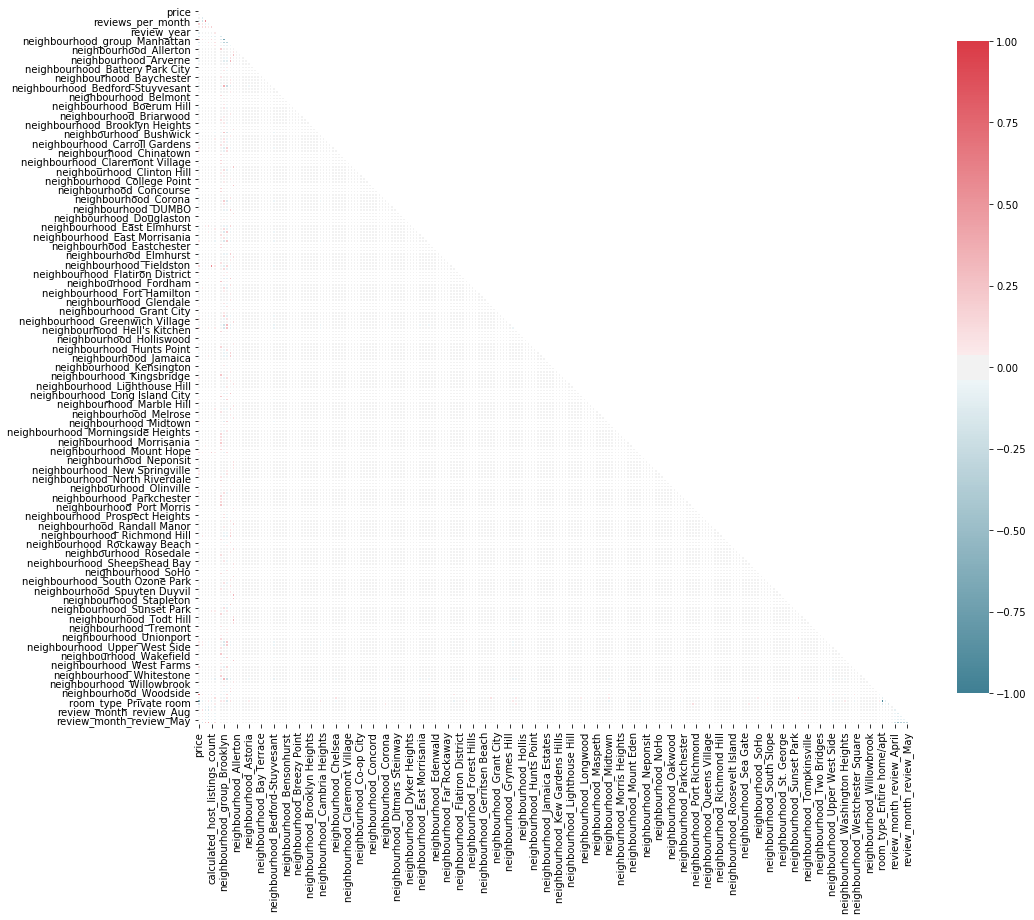

In [55]:
f, ax = plt.subplots(figsize=(16, 16))

mask = np.zeros_like(corr19_1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr19_1,          # The data to plot
    mask=mask,     # Mask upper-right cells
    cmap=cmap,    
    annot=False,    # don't plot values in the cells
    vmax=1,      
    vmin=-1,     
    center=0,      
    square=True,   # make square cells 
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .75}  # Extra kwargs for the legend; in this case, shrink to 75%
)


f.savefig('correlation matrix_heatmap.png')

* 2. correlation matrix for cleaned_df19_Lneighbour dataset which includes only 5 large neighbourhood groups

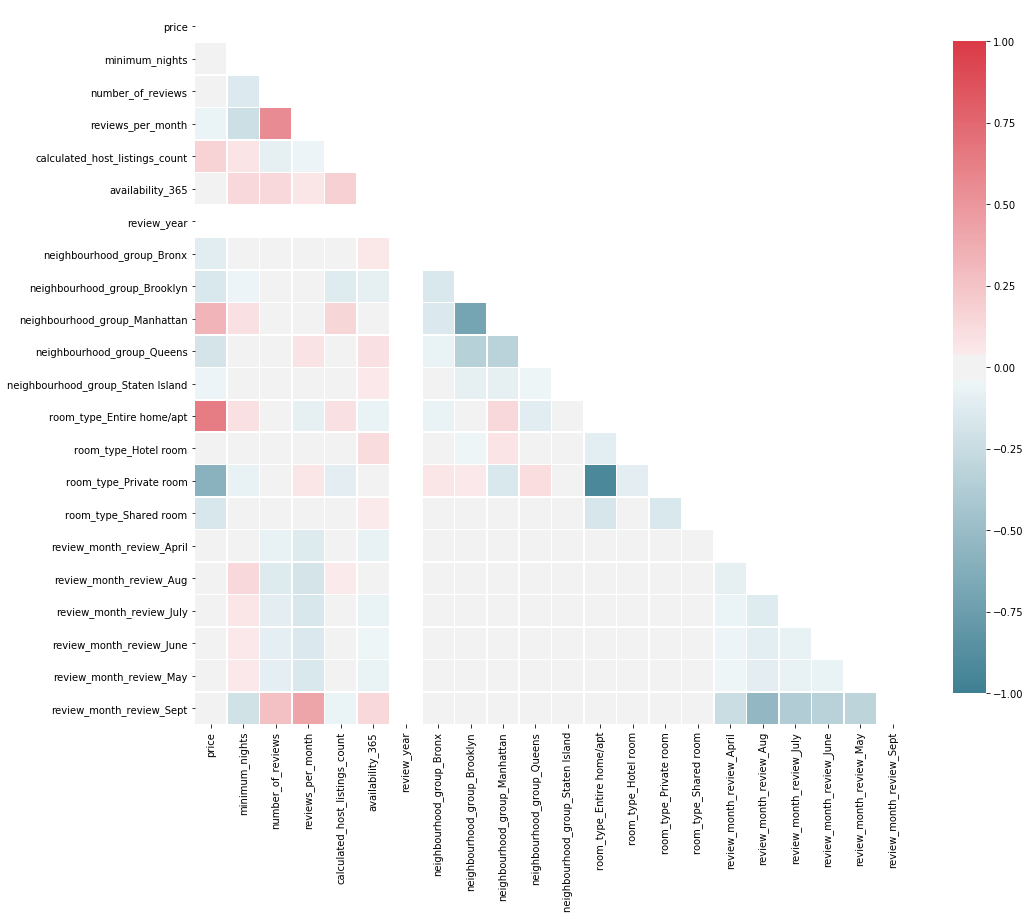

In [56]:
f, ax = plt.subplots(figsize=(16, 16))

mask = np.zeros_like(corr19_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr19_2,          # The data to plot
    mask=mask,     # Mask upper-right cells
    cmap=cmap,    
    annot=False,    # don't plot values in the cells
    vmax=1,      
    vmin=-1,     
    center=0,      
    square=True,   # make square cells 
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .75}  # Extra kwargs for the legend; in this case, shrink to 75%
)


f.savefig('correlation matrix_heatmap.png')

* The number_of_reviews and reviews_per_month are highly correlated. So reviews_per_month will be deleted from the datasets.\
It will be done for both dataset.

In [57]:
cleaned_df19_Lneighbour = cleaned_df19_Lneighbour.drop(['reviews_per_month'],axis=1)
cleaned_df19 = cleaned_df19.drop(['reviews_per_month'],axis=1)

In [58]:
cleaned_df20_Lneighbour = cleaned_df20_Lneighbour.drop(['reviews_per_month'],axis=1)
cleaned_df20 = cleaned_df20.drop(['reviews_per_month'],axis=1)

### Build training and testing datasets

* 1. For the cleaned_df19, cleaned_df20 with specific neighbourhood area (200+ columns)

In [59]:
X19 = cleaned_df19.drop('price', axis=1)
y19 = cleaned_df19.price
# Scaling
#scaler = StandardScaler()
#X19 = pd.DataFrame(scaler.fit_transform(X19), columns=list(X19.columns))
# Randomly split into trainning and testing datasets 8:2
X_train19, X_test19, y_train19, y_test19 = train_test_split(X19, y19, test_size=0.2, random_state=123)

In [60]:
X20 = cleaned_df20.drop('price', axis=1)
y20 = cleaned_df20.price
# Scaling
#scaler = StandardScaler()
#X20 = pd.DataFrame(scaler.fit_transform(X20), columns=list(X20.columns))
# Randomly split into trainning and testing datasets 8:2
X_train20, X_test20, y_train20, y_test20 = train_test_split(X20, y20, test_size=0.2, random_state=123)

* 2. For the cleaned_df19_Lneighbour, cleaned_df20_Lneighbour with only large neighbourhood group

In [61]:
X19_L = cleaned_df19_Lneighbour.drop('price', axis=1)
y19_L = cleaned_df19_Lneighbour.price
# Scaling
#scaler = StandardScaler()
#X19_L = pd.DataFrame(scaler.fit_transform(X19_L), columns=list(X19_L.columns))
# Randomly split into trainning and testing datasets 8:2
X_train19_L, X_test19_L, y_train19_L, y_test19_L = train_test_split(X19_L, y19_L, test_size=0.2, random_state=123)

In [62]:
X20_L = cleaned_df20_Lneighbour.drop('price', axis=1)
y20_L = cleaned_df20_Lneighbour.price
# Scaling
#scaler = StandardScaler()
#X19_L = pd.DataFrame(scaler.fit_transform(X19_L), columns=list(X19_L.columns))
# Randomly split into trainning and testing datasets 8:2
X_train20_L, X_test20_L, y_train20_L, y_test20_L = train_test_split(X20_L, y20_L, test_size=0.2, random_state=123)

In [63]:
X_train19.to_excel('data/X_train19.xlsx')
y_train19.to_excel('data/y_train19.xlsx')
X_test19.to_excel('data/X_test19.xlsx')
y_test19.to_excel('data/y_test19.xlsx')

In [64]:
X_train20.to_excel('data/X_train20.xlsx')
y_train20.to_excel('data/y_train20.xlsx')
X_test20.to_excel('data/X_test20.xlsx')
y_test20.to_excel('data/y_test20.xlsx')

In [65]:
X_train19_L.to_excel('data/X_train19_L.xlsx')
y_train19_L.to_excel('data/y_train19_L.xlsx')
X_test19_L.to_excel('data/X_test19_L.xlsx')
y_test19_L.to_excel('data/y_test19_L.xlsx')

In [66]:
X_train20_L.to_excel('data/X_train20_L.xlsx')
y_train20_L.to_excel('data/y_train20_L.xlsx')
X_test20_L.to_excel('data/X_test20_L.xlsx')
y_test20_L.to_excel('data/y_test20_L.xlsx')

### Build XGBoost

In [ ]:
xgb_reg_start = time.time()

xgb_reg1 = xgb.XGBRegressor()
xgb_reg1.fit(X_train19, y_train19)
training_preds_19 = xgb_reg1.predict(X_train19)
val_preds_19 = xgb_reg1.predict(X_test19)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train19, training_preds_19),4))
print("Validation MSE:", round(mean_squared_error(y_test19, val_preds_19),4))
print("\nTraining r2:", round(r2_score(y_train19, training_preds_19),4))
print("Validation r2:", round(r2_score(y_test19, val_preds_19),4))

In [ ]:
xgb_reg_start = time.time()

xgb_reg3 = xgb.XGBRegressor()
xgb_reg3.fit(X_train19_L, y_train19_L)
training_preds_19_L = xgb_reg3.predict(X_train19_L)
val_preds_19_L = xgb_reg3.predict(X_test19_L)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train19_L, training_preds_19_L),4))
print("Validation MSE:", round(mean_squared_error(y_test19_L, val_preds_19_L),4))
print("\nTraining r2:", round(r2_score(y_train19_L, training_preds_19_L),4))
print("Validation r2:", round(r2_score(y_test19_L, val_preds_19_L),4))

In [ ]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train20, y_train20)
training_preds_20 = xgb_reg2.predict(X_train20)
val_preds_20 = xgb_reg2.predict(X_test20)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train20, training_preds_20),4))
print("Validation MSE:", round(mean_squared_error(y_test20, val_preds_20),4))
print("\nTraining r2:", round(r2_score(y_train20, training_preds_20),4))
print("Validation r2:", round(r2_score(y_test20, val_preds_20),4))

In [ ]:
xgb_reg_start = time.time()

xgb_reg4 = xgb.XGBRegressor()
xgb_reg4.fit(X_train20_L, y_train20_L)
training_preds_20_L = xgb_reg4.predict(X_train20_L)
val_preds_20_L = xgb_reg4.predict(X_test20_L)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train20_L, training_preds_20_L),4))
print("Validation MSE:", round(mean_squared_error(y_test20_L, val_preds_20_L),4))
print("\nTraining r2:", round(r2_score(y_train20_L, training_preds_20_L),4))
print("Validation r2:", round(r2_score(y_test20_L, val_preds_20_L),4))

In [ ]:
ft_weights_xgb_reg19 = pd.DataFrame(xgb_reg1.feature_importances_, columns=['weight'], index=X_train19.columns)
ft_weights_xgb_reg19.sort_values('weight', inplace=True)
ft_weights_xgb_reg19

In [ ]:
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg19.index, ft_weights_xgb_reg19.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
ft_weights_xgb_reg2 = pd.DataFrame(xgb_reg2.feature_importances_, columns=['weight'], index=X_train20.columns)
ft_weights_xgb_reg2.sort_values('weight', inplace=True)
ft_weights_xgb_reg2

In [ ]:
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg2.index, ft_weights_xgb_reg2.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1
from keras import optimizers

In [ ]:
def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))

def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))


In [ ]:
def svm(X_train, y_train, X_val, y_val):
    model = SVR(gamma = 0.05, verbose = True) #was empty #0.1 #the - best gamma 0.05, c=0.5
    model.fit(X_train, y_train)
    print_evaluation_metrics(model, "svm", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "svm", X_train, y_train.values.ravel())

In [ ]:
svm(X_train19,y_train19, X_test19, y_test19)

In [ ]:
svm(X_train20,y_train20, X_test20, y_test20)